# Linear Regression in Python- Predicting Age in Census Data

## Introduction

The objective of this project is to predict the age of an individual with the 1994 US Census Data using multiple linear regression. We use the `Statsmodels` and `Patsy` modules for this task with Python version >= 3.6. The `Patsy` module is going to allow us to create formulas to use in conjunction with the `Statsmodels` output. The dataset was sourced from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/adult <cite data-cite="adult_uci">(Lichman, 2013)</cite>. 

## Overview

### Data Source

The UCI Machine Learning Repository provides five datasets, but only `adult.data`and `adult.test` are used in this project. The `adult.data` and `adult.test` are the training and test datasets respectively. The `adult.names` file contains the details of the variables (a.k.a. features or attributes). It is not included, but is summarized briefly below. The training dataset has 32,561 observations (a.k.a. instances or records) and the test dataset has 16,281 observations. Both datasets consist of 14 descriptive (a.k.a. independent) features and one target (a.k.a. response or dependent) feature. In this project, we combine both training and test data into one. 

Please note that these files have been downloaded and saved as .txt files for you to limit the data download drain during the zoom session.


### Project Objective

Our goal is to see if we can predict an individual's age within an acceptable margin of error using multiple linear regression primarily with just main affects.


### Target Feature

Our target feature is `age`, which is a continuous numerical feature. Hence, our project is on a regression problem.


### Descriptive Features

The variable descriptions below are from the `adult.names` file: 

- **`workclass`**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **`fnlwgt`**: continuous.
- **`education`**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **`education-num`**: continuous.
- **`marital-status`**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- **`occupation`**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-*inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **`relationship`**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **`race`**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **`sex`**: Female, Male.
- **`capital-gain`**: continuous.
- **`capital-loss`**: continuous.
- **`hours-per-week`**: continuous.
- **`native-country`**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- **`income`**: binary, 1: earns over \\$50k a year, 0: earns less than \\$50k a year.

Most of the descriptive features are self-explanatory, except `fnlwgt` which stands for "Final Weight" defined by the US Census. This weight is an "estimate of the number of units in the target population that the responding unit represents" (Lichman, 2013). This feature aims to allocate similar weights to people with similar demographic characteristics.


## Data Preparation

### Preliminaries

First, let's import all the common modules we will be using. IF you get error messages related to a failed import, you may need to install the respective library first. Use either conda install or pip install. This will be necessary for `statsmodels` and `patsy`.

In [1]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
###
warnings.filterwarnings('ignore')
###
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

We read the training and test datasets from the data that have been pre-downloaded and saved for you. Also, since the datasets do not contain the attribute names, they are explicitly specified during data loading process. The `adultData` dataset is read first and then it is concatenated with `adultTest` as just `data`.

In [2]:
# Gettting data from the web- do not execute this block unless you want to pull the data directly by URL
# If you wish to use this block, insert in place of the section under Read in Data below
#url = (
#    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
#    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
#)


In [2]:
# Specifying the attribute names
attributeNames = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

# Read in data
adultData = pd.read_csv('adult_data.txt', sep = ',', names = attributeNames, header = None)
adultTest = pd.read_csv('adult_test.txt', sep = ',', names = attributeNames, skiprows = 1)

# Join the two datasets together
data = pd.concat([adultData,adultTest])

# we will not need the datasets below anymore, so let's delete them to save memory
del adultData, adultTest

# Display randomly selected 10 rows
data.sample(10, random_state=999)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
30807,62,Self-emp-not-inc,224520,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,90,United-States,>50K
23838,32,Private,262153,HS-grad,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,35,United-States,<=50K
24124,41,Private,39581,Some-college,10,Divorced,Adm-clerical,Not-in-family,Black,Female,0,0,24,El-Salvador,<=50K
22731,66,?,186032,Assoc-voc,11,Widowed,?,Not-in-family,White,Female,2964,0,30,United-States,<=50K
2975,27,Private,37933,Some-college,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
4457,31,State-gov,93589,HS-grad,9,Divorced,Protective-serv,Own-child,Other,Male,0,0,40,United-States,<=50K
32318,34,Private,117963,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
12685,61,Self-emp-not-inc,176965,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
2183,47,Private,156926,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K.


### Data Cleaning and Transformation

We first confirm that the feature types match the descriptions outlined in the documentation.

In [3]:
print(f"Shape of the dataset is {data.shape} \n")
print(f"Data types are below where 'object' indicates a string type: ")
print(data.dtypes)

Shape of the dataset is (48842, 15) 

Data types are below where 'object' indicates a string type: 
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


### Checking for Missing Values

In [4]:
print(f"\nNumber of missing values for each feature:")
print(data.isnull().sum())


Number of missing values for each feature:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


On surface, no attribute contains any missing values, though we shall see below that the missing values are coded with a question mark. We will address this issue later.

### Summary Statistics

In [5]:
from IPython.display import display, HTML
display(HTML('<b>Table 1: Summary of continuous features</b>'))
data.describe(include='int64')

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
display(HTML('<b>Table 2: Summary of categorical features</b>'))
data.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


Table 2 shows the feature `income` has four categories (or a cardinality of 4). It was supposed to be 2 since income must be binary. We will fix this cardinality issue later.

### Continuous Features

As discussed earlier, the `fnlwgt` variable has no predictive power, so it is removed. In addition, since we have an education categorical feature, we will go ahead and remove the `education-num` feature as it relays the same information and is therefore redundant.

In [7]:
data = data.drop(columns=['fnlwgt', 'education-num'])

In [8]:
data['age'].describe()

count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

The range of `age` appears reasonable as the minimum and maximum ages are 17 and 90 respectively. 

Next, we define `capital = capital-gain - capital-loss` and then remove the individual gain and loss variables. The summary statistic for `capital` is displayed below.

In [9]:
data['capital'] = data['capital-gain'] - data['capital-loss']
data = data.drop(columns=['capital-gain', 'capital-loss'])
data['capital'].describe()

count    48842.000000
mean       991.565313
std       7475.549906
min      -4356.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital, dtype: float64

### Fixing Column Names

Some column names contain a minus sign, which can be problematic when modeling. Basically, when we write the regression formula, a minus sign will mean "exclude this variable", which is clearly not our intent here. For this reason, we modify the column names so that the minus signs are replaced with an underscore sign.

In [10]:
data.columns = [colname.replace('-', '_') for colname in list(data.columns)]
data.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income,capital
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,2174
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,0


### Categorical Features

Let's have a look at the unique values of the categorical columns. In `Pandas`, string types are of data type "object", and usually these would be the categorical features.

In [11]:
categoricalColumns = data.columns[data.dtypes==object].tolist()

for col in categoricalColumns:
    print('Unique values for ' + col)
    print(data[col].unique())
    print('')

Unique values for workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']

Unique values for education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']

Unique values for marital_status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']

Unique values for occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']

Unique values for relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']

Unique values for race
[' White' ' Black' ' Asian-Pac-Islander' ' Ame

Some categorical attributes contain excessive white spaces, which makes life hard when filtering data. We will apply the `strip()` function to remove extra white spaces.

In [12]:
for col in categoricalColumns:
    data[col] = data[col].str.strip()

**WARNING:** The `Statsmodels` module does not play nice when you have a minus sign in levels of categorical variables, especially when you try to some sort of automatic variable selection. The reason is that the minus sign has a special meaning in the underlying `Patsy` module: it means remove this feature. So, we will replace all the minus signs in categorical variable level names with an underscore sign. In addition, a dot sign is also not allowed.

In [13]:
for col in categoricalColumns:
    data[col] = data[col].str.replace('-', '_')
data.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income,capital
0,39,State_gov,Bachelors,Never_married,Adm_clerical,Not_in_family,White,Male,40,United_States,<=50K,2174
1,50,Self_emp_not_inc,Bachelors,Married_civ_spouse,Exec_managerial,Husband,White,Male,13,United_States,<=50K,0
2,38,Private,HS_grad,Divorced,Handlers_cleaners,Not_in_family,White,Male,40,United_States,<=50K,0
3,53,Private,11th,Married_civ_spouse,Handlers_cleaners,Husband,Black,Male,40,United_States,<=50K,0
4,28,Private,Bachelors,Married_civ_spouse,Prof_specialty,Wife,Black,Female,40,Cuba,<=50K,0


The `workclass`, `occupation`, and `native-country` features contain some missing values encoded as "?". These observations comprise 7.4% of the total number of observations.

In [14]:
mask = (data['workclass'] == '?') | (data['occupation'] == '?') | (data['native_country'] == '?')
mask.value_counts(normalize = True)*100

False    92.588346
True      7.411654
dtype: float64

We now remove the rows with missing occupation, workclass, and native-country where missing values are encoded as "?".

In [15]:
data = data[data['workclass'] != "?"] 
data = data[data['occupation'] != "?"] 
data = data[data['native_country'] != "?"]

Since `native-country` is too granular and unbalanced, we group countries as "Other" and "United_States". Likewise, we also categorize races as "Other" and "White".

In [16]:
data.loc[data['native_country'] != 'United_States', 'native_country'] = 'Other'
data.loc[data['race'] != 'White', 'race'] = 'Other'

**TIP 1**: As a general comment, sometimes numerical features in a dataset actually represent categorical features. As an example, suppose each state of Australia is encoded as an integer between 1 and 8, say as `StateID` column in a dataframe called `df`. This would still be a categorical variable. For your code to work correctly in such cases, you need to change the data type of this column from numeric to string as follows:
```Python
df['StateID'] = df['StateID'].astype(str)
```
**TIP 2**: If you have a string column, say named `col`, that is actually real-valued, you can change its data type as follows:
```Python
df['col'] = df['col'].astype(float)
```

### Dependent Variable

We need to correct the levels of the `income` categorical feature, which is our dependent variable, to make sure it is binary.

In [17]:
print('Before correction, the number of unique income labels are: ')
print(data['income'].value_counts())
print("")

data['income'] = data['income'].str.rstrip(".")

print('After removing the dot, the number of unique income labels are: ')
print(data['income'].value_counts())
print("")

Before correction, the number of unique income labels are: 
<=50K     22654
<=50K.    11360
>50K       7508
>50K.      3700
Name: income, dtype: int64

After removing the dot, the number of unique income labels are: 
<=50K    34014
>50K     11208
Name: income, dtype: int64



**WARNING:** The `Statsmodels` module does not play nice when you have mathematical symbols such as "-", "+", "<" and ">" in levels of categorical variables (try it and you will get a syntax error). For this reason, we will re-code income as `low` and `high` as below using the `replace()` function in `Pandas`.

In [18]:
data['income'] = data['income'].replace({'<=50K': 'low', '>50K': 'high'})
data['income'].value_counts()

low     34014
high    11208
Name: income, dtype: int64

## Data Exploration 

Our dataset can now be considered "clean" and ready for visualisation and statistical modeling.


### Univariate Visualisation

Let's get a bar chart of native country.

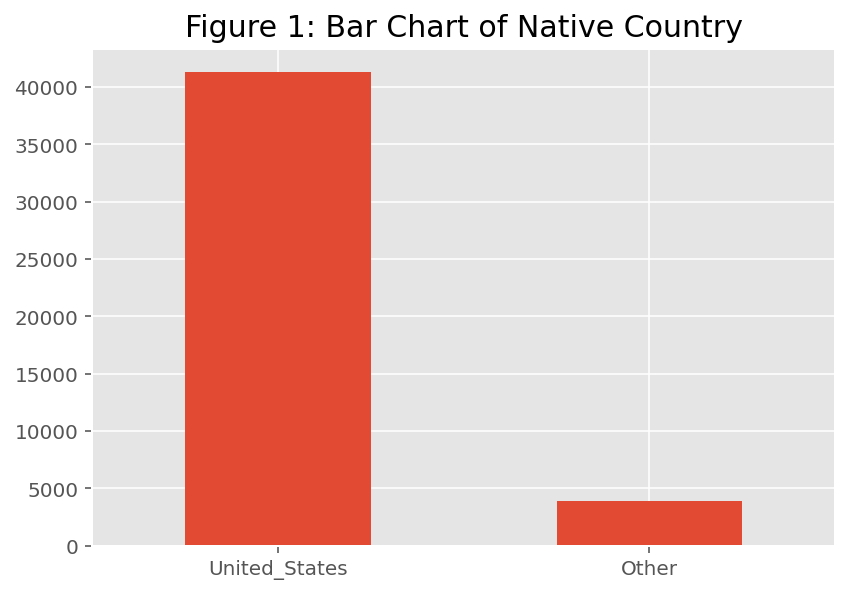

In [20]:
ax = data['native_country'].value_counts().plot(kind = 'bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.tight_layout()
plt.title('Figure 1: Bar Chart of Native Country', fontsize = 15)
plt.show();

Let's display a boxplot and histogram for `age`. Figure 2 shows that this variable is right-skewed. Note that we are adding a line to save the plot. When we use savefig, it must be done before showing the plot.

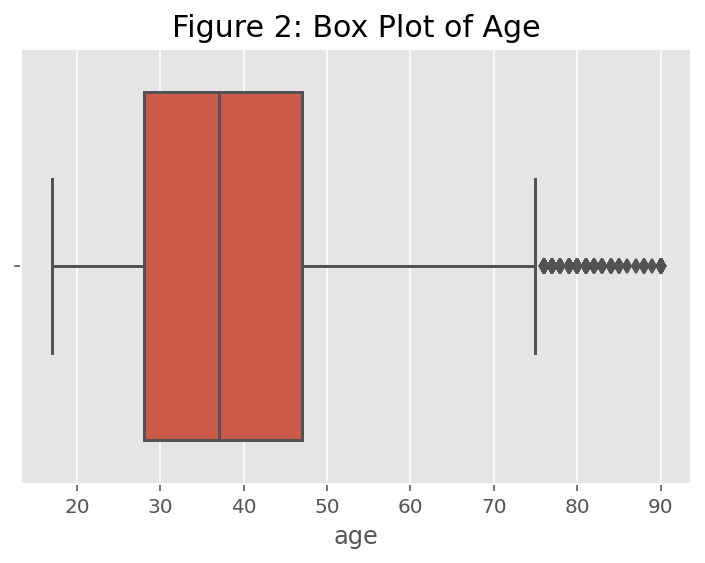

In [22]:
# get a box plot of age
sns.boxplot(data['age']).set_title('Figure 2: Box Plot of Age', fontsize = 15)
plt.savefig('boxplotage.png')
plt.show();

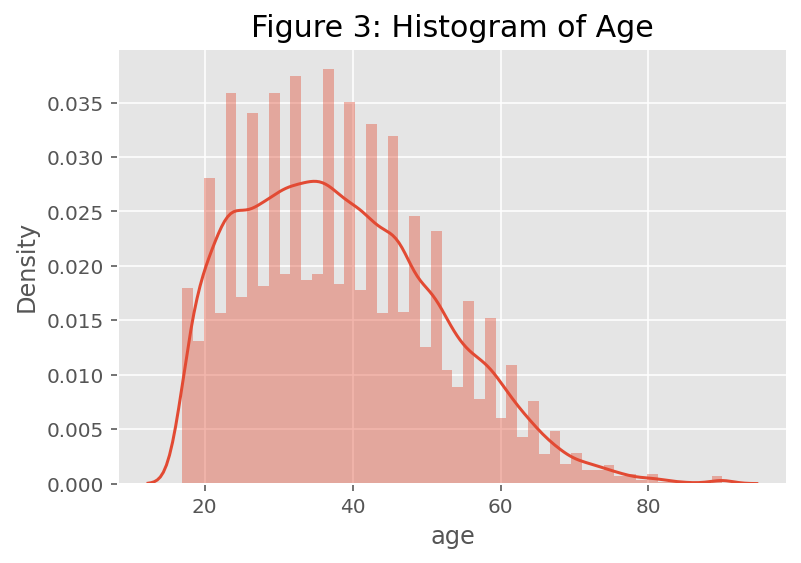

In [23]:
# get a histogram of age with kernel density estimate
sns.distplot(data['age'], kde = True).set_title('Figure 3: Histogram of Age', fontsize = 15)
plt.show();

### Multivariate Visualisation

#### Scatterplot of Numeric Features and Age

The scatterplot in Figure 4 shows no clear correlation between the age and hours_per_week numeric variables.

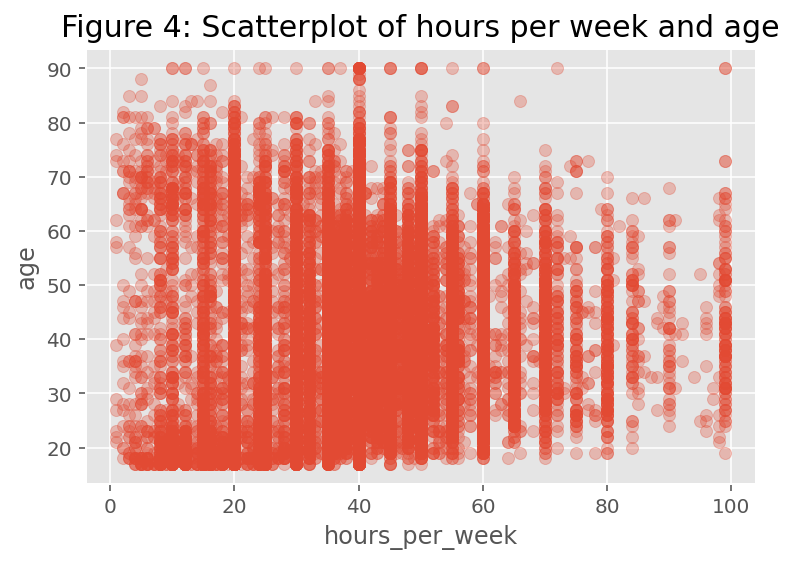

In [24]:
# store the values of hours-per-week
hpw = data['hours_per_week']

# get a scatter plot
plt.scatter(hpw, data['age'], alpha = 0.3)
plt.title('Figure 4: Scatterplot of hours per week and age', fontsize = 15)
plt.xlabel('hours_per_week')
plt.ylabel('age')
plt.show();

#### Categorical Attributes by Age

We can see that the distribution of age between each gender is similar.

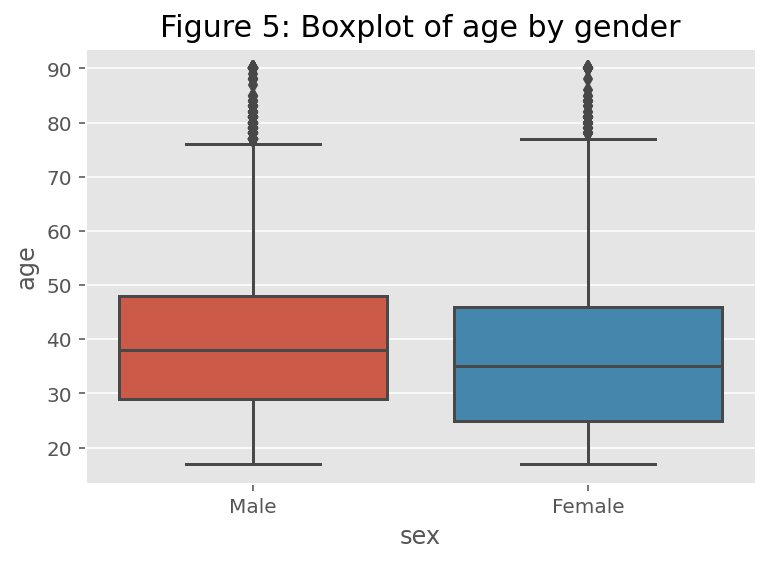

In [25]:
# Creating a boxplot
sns.boxplot(data['sex'], data['age']);
plt.title('Figure 5: Boxplot of age by gender', fontsize = 15)
plt.show();

The distribution of married women and single women differ but have a similar median as seen in Figure 6. The whiskers suggest that women above the age of 70 are more likely to be single.

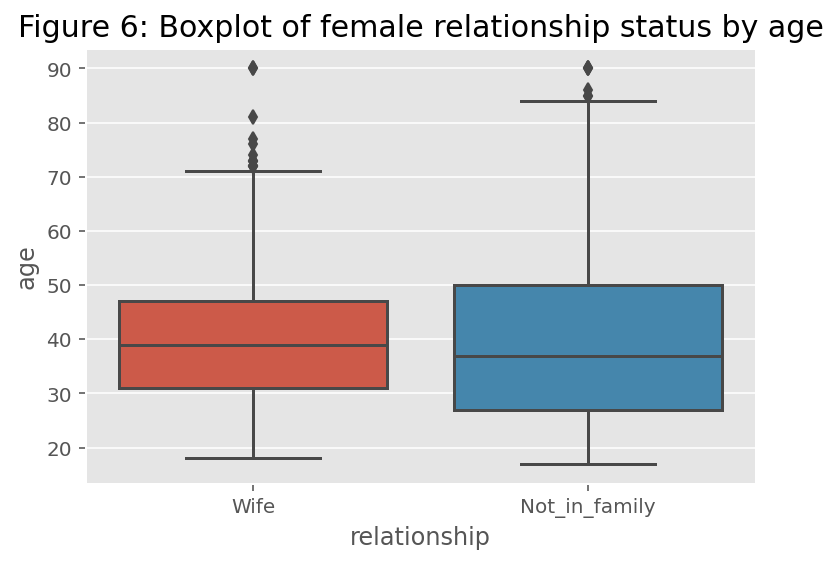

In [26]:
# Storing a list of booleans corresponding to whether the person is female and a wife or Not_in_family
family_female_mask = (data['relationship'].isin(['Not_in_family','Wife'])) & (data['sex'].isin(['Female']))

# Using the list of booleans previously found to select the index of rows
family_female = data[family_female_mask]

# Creating the boxplot
sns.boxplot(family_female['relationship'], family_female['age']);
plt.title('Figure 6: Boxplot of female relationship status by age', fontsize = 15)
plt.show();

#### Facet plots

From Figure 7, we see that generally the distribution of male bachelors and high school graduates is somewhat comparable within each relationship level.

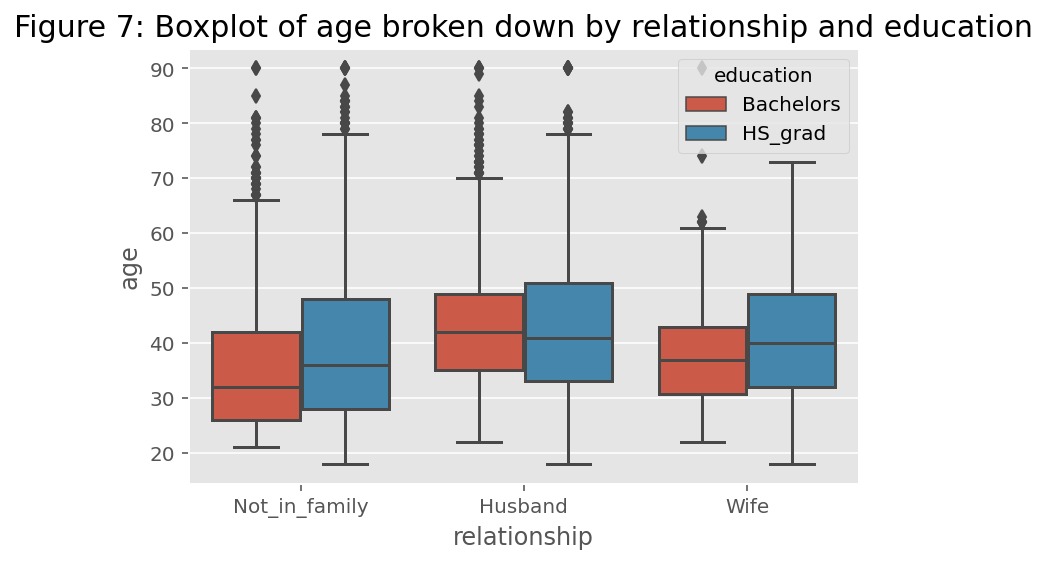

In [27]:
# Getting the index of those who have completed their Bachelors or HS graduate
edu_mask = data['education'].isin(['Bachelors','HS_grad'])

# Getting the index of those who are male and Not_in_family or a Husband
family_male_mask = (data['relationship'].isin(['Not_in_family','Husband'])) & (data['sex'].isin(['Male']))

# Selecting the rows of those who are Not_in_family, husband or wife and 
# have completed either a Bachelors or just graduated high school
education_relationship = data[(edu_mask & family_female_mask) | (edu_mask & family_male_mask)]

# Creating the boxplot
sns.boxplot(education_relationship['relationship'], education_relationship['age'], 
            hue = education_relationship['education'])
plt.title('Figure 7: Boxplot of age broken down by relationship and education', fontsize = 15)
plt.show();

Although there is no clear overall pattern, we observe in Figure 8 that no government worker under the age of 40 earns over \\$50k a year unless they work more than 20 hours a week. 

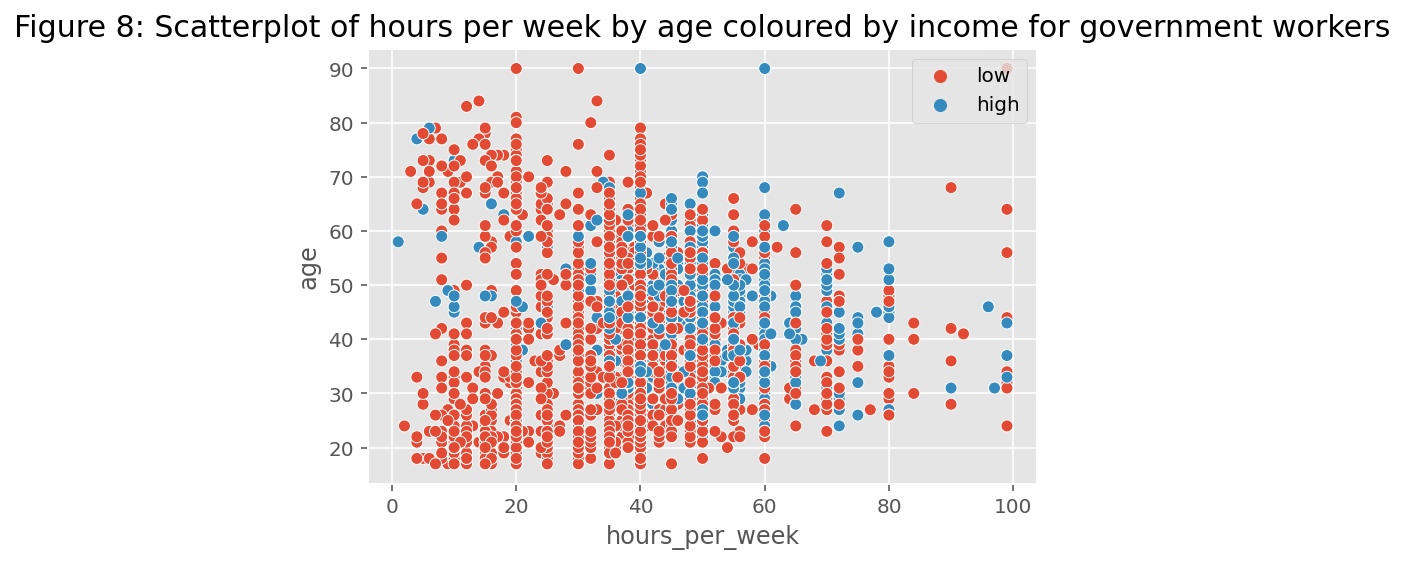

In [28]:
# Getting the index of those who work in the government
gov_mask = data['workclass'].isin(['Federal_gov','Local_gov','State_gov'])

# creating a dataframe of those who work in the government
gov = data[gov_mask]

# creating a scatterplot
sns.scatterplot(gov['hours_per_week'], gov['age'], hue = gov['income'])
plt.title('Figure 8: Scatterplot of hours per week by age coloured by income for government workers', fontsize = 15);
plt.legend(loc = 'upper right')
plt.show();

## Statistical Modeling and Performance Evaluation

### Full Model

We begin by fitting a multiple linear regression that predicts `age` using all of the avaliable features. We call this the full model. First let's take a quick peak at the clean data.

In [29]:
data.head()

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income,capital
0,39,State_gov,Bachelors,Never_married,Adm_clerical,Not_in_family,White,Male,40,United_States,low,2174
1,50,Self_emp_not_inc,Bachelors,Married_civ_spouse,Exec_managerial,Husband,White,Male,13,United_States,low,0
2,38,Private,HS_grad,Divorced,Handlers_cleaners,Not_in_family,White,Male,40,United_States,low,0
3,53,Private,11th,Married_civ_spouse,Handlers_cleaners,Husband,Other,Male,40,United_States,low,0
4,28,Private,Bachelors,Married_civ_spouse,Prof_specialty,Wife,Other,Female,40,Other,low,0


When constructing the regression formula, we can manually add all the independent features. On the other hand, if there are lots of independent variables, we can get smart and use some string function tricks as below.

In [30]:
# short and sweet
formula_string_indep_vars = ' + '.join(data.drop(columns='age').columns)
formula_string = 'age ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  age ~ workclass + education + marital_status + occupation + relationship + race + sex + hours_per_week + native_country + income + capital


The formula string above works just fine with the `Statsmodels` module. The problem, however, is that we cannot do automatic variable selection with this formula. What we need for this purpose is "one-hot-encoding" of categorical features.

In the code chunk below, we first use the `get_dummies()` function in `Pandas` for one-hot-encoding of categorical features and then we construct a new formula string with the encoded features.

In [31]:
# one-hot-encoding of categorical features
# for this to work correctly, variable data types (numeric or categorical)
# must be correctly specified within the Pandas dataframe
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head()

,age,hours_per_week,capital,workclass_Local_gov,workclass_Private,workclass_Self_emp_inc,workclass_Self_emp_not_inc,workclass_State_gov,workclass_Without_pay,education_11th,...,occupation_Transport_moving,relationship_Not_in_family,relationship_Other_relative,relationship_Own_child,relationship_Unmarried,relationship_Wife,race_White,sex_Male,native_country_United_States,income_low
0,39,40,2174,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,1,1,1
1,50,13,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,38,40,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,1,1
3,53,40,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1
4,28,40,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [32]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='age').columns)
formula_string_encoded = 'age ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  age ~ hours_per_week + capital + workclass_Local_gov + workclass_Private + workclass_Self_emp_inc + workclass_Self_emp_not_inc + workclass_State_gov + workclass_Without_pay + education_11th + education_12th + education_1st_4th + education_5th_6th + education_7th_8th + education_9th + education_Assoc_acdm + education_Assoc_voc + education_Bachelors + education_Doctorate + education_HS_grad + education_Masters + education_Preschool + education_Prof_school + education_Some_college + marital_status_Married_AF_spouse + marital_status_Married_civ_spouse + marital_status_Married_spouse_absent + marital_status_Never_married + marital_status_Separated + marital_status_Widowed + occupation_Armed_Forces + occupation_Craft_repair + occupation_Exec_managerial + occupation_Farming_fishing + occupation_Handlers_cleaners + occupation_Machine_op_inspct + occupation_Other_service + occupation_Priv_house_serv + occupation_Prof_specialty + occupation_Protective_serv + occupation_S

For fun, let's add two interaction terms to our full model. Let's add the interaction of the `capital` feature with `hours_per_week` and `race_White` respectively. 

In [33]:
formula_string_encoded = formula_string_encoded + ' + hours_per_week:capital + race_White:capital'

Also, let's add the square of the `hours_per_week` feature to illustrate how we can add higher order terms to our linear regression.

In [34]:
formula_string_encoded = formula_string_encoded + ' + np.power(hours_per_week, 2)'
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  age ~ hours_per_week + capital + workclass_Local_gov + workclass_Private + workclass_Self_emp_inc + workclass_Self_emp_not_inc + workclass_State_gov + workclass_Without_pay + education_11th + education_12th + education_1st_4th + education_5th_6th + education_7th_8th + education_9th + education_Assoc_acdm + education_Assoc_voc + education_Bachelors + education_Doctorate + education_HS_grad + education_Masters + education_Preschool + education_Prof_school + education_Some_college + marital_status_Married_AF_spouse + marital_status_Married_civ_spouse + marital_status_Married_spouse_absent + marital_status_Never_married + marital_status_Separated + marital_status_Widowed + occupation_Armed_Forces + occupation_Craft_repair + occupation_Exec_managerial + occupation_Farming_fishing + occupation_Handlers_cleaners + occupation_Machine_op_inspct + occupation_Other_service + occupation_Priv_house_serv + occupation_Prof_specialty + occupation_Protective_serv + occupation_S

Now that we have defined our statistical model formula as a Python string, we fit an OLS (ordinary least squares) model to our encoded data.

In [35]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     571.3
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:45:01   Log-Likelihood:            -1.6914e+05
No. Observations:               45222   AIC:                         3.384e+05
Df Residuals:                   45167   BIC:                         3.389e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


The full model has an adjusted R-squared value of 0.405, which means that only 40% of the variance is explained by the model. By looking at the p-values, we observe that the majority of them are highly significant, though there are a few insignificant variables at a 5% level. 

Let's define a new data frame for actual age vs. predicted age and the residuals for the full model. We will use this data frame when plotting predicted values and the regression residuals.

In [36]:
residuals_full = pd.DataFrame({'actual': data_encoded['age'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.head(10)

,actual,predicted,residual
0,39,32.570133,6.429867
1,50,49.455511,0.544489
2,38,41.508711,-3.508711
3,53,37.683573,15.316427
4,28,36.097893,-8.097893
5,37,40.570690,-3.570690
6,49,44.495664,4.504336
7,52,49.611524,2.388476
8,31,35.683539,-4.683539
9,42,44.318118,-2.318118


Let's plot actual age values vs. predicted values.

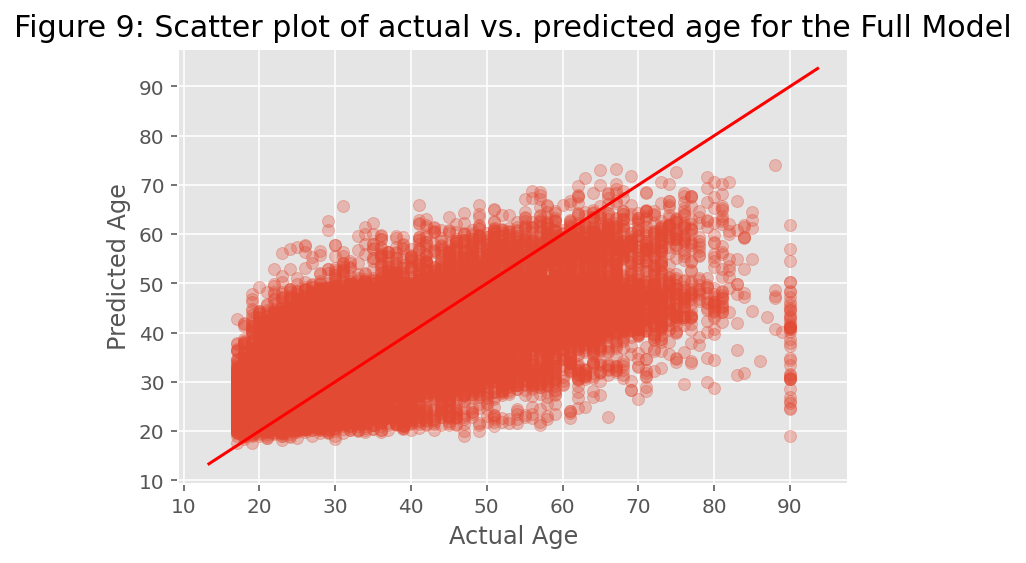

In [37]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Age');
plt.ylabel('Predicted Age');
plt.title('Figure 9: Scatter plot of actual vs. predicted age for the Full Model', fontsize=15);
plt.show();

From Figure 9, we observe that the model never produces a prediction above 80 even though the oldest person in the dataset is 90.

We will now check the diagnostics for the full model.

### Full Model Diagnostic Checks

We would like to check whether there are indications of violations of the regression assumptions, which are
1. linearity of the relationship between target variable and the independent variables
2. constant variance of the errors
3. normality of the residual distribution
4. statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted `age`).

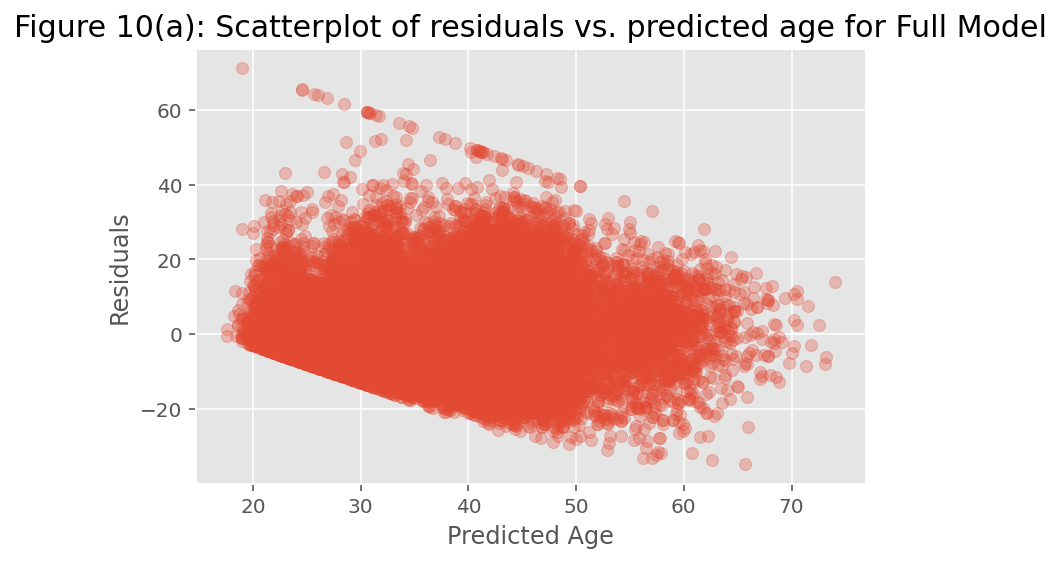

In [38]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Age');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted age for Full Model', fontsize=15)
plt.show();

From Figure 10(a), we see that, rather than being mostly random and centered around 0, the residuals exhibit a banding pattern, especially when predicted age is below 50. This pattern indicates that the constant variability assumption of linear regression is not quite satisfied in this case. 

Let's now plot actual age vs. residuals.

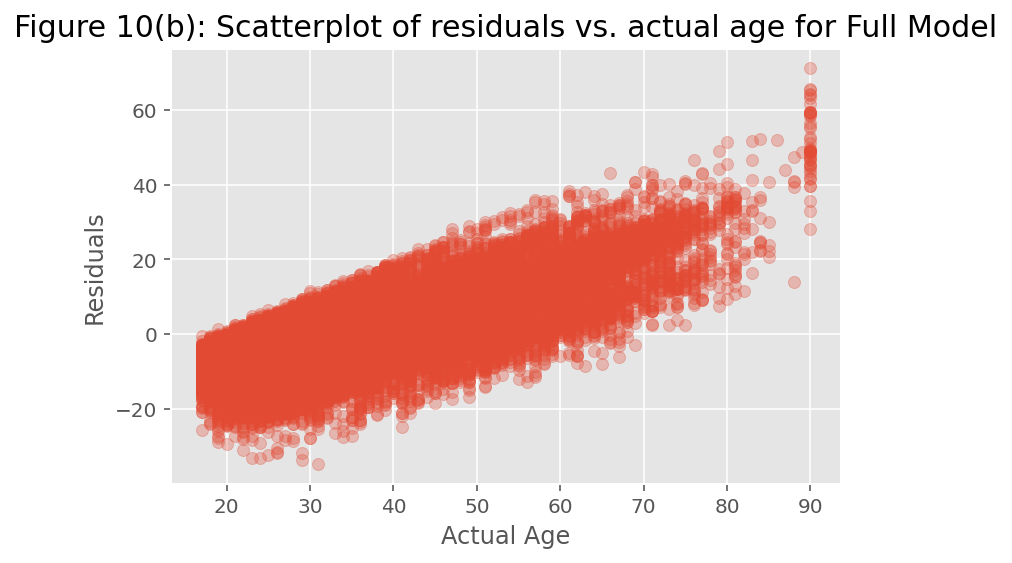

In [39]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Age');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual age for Full Model', fontsize=15)
plt.show();

We notice that the model overestimates younger ages and underestimates older ages. In particular, for those younger than the age of 30, the model predicts much older ages. Also, for those above the age of 80, the model predicts significantly younger ages. 

Let's overlay the histograms of actual vs. predicted age on the same plot.

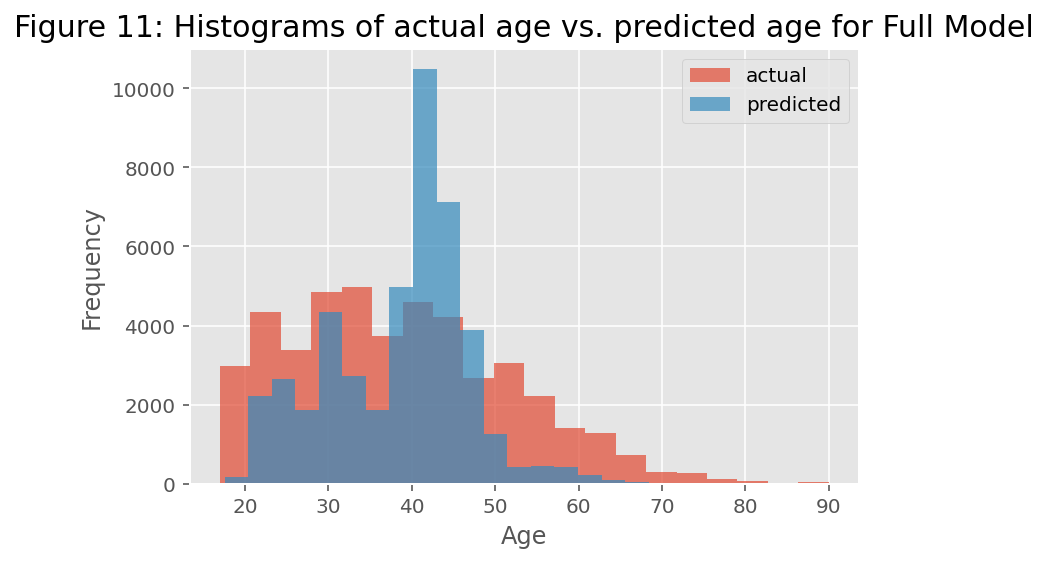

In [40]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Age');
plt.ylabel('Frequency');
plt.title('Figure 11: Histograms of actual age vs. predicted age for Full Model', fontsize=15);
plt.legend()
plt.show();

We notice that their distributions are quite different. In particular, the model's predictions are highly clustered around mid-40's. 

Let's now have look at the histogram of the residuals.

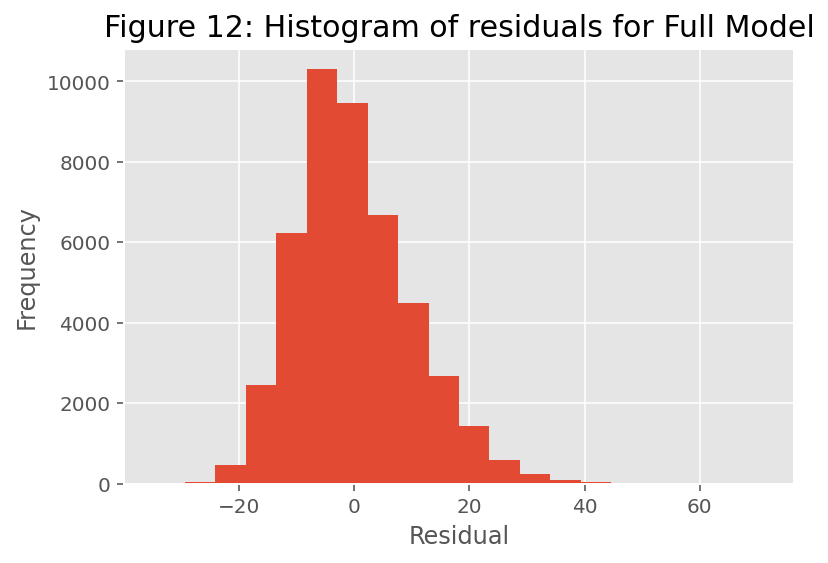

In [41]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

From Figure 12, the histogram of residuals looks somewhat symmetric, though slightly right-skewed. Nonetheless, it seems the normality assumption of linear regression is not significantly violated in this particular case.

### Backwards Feature Selection

We now perform backwards feature selection using p-values. It appears `Statsmodels` does not have any canned code for automatic feature selection, so we must write one.

In [42]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "occupation_Farming_fishing" with p-value 0.984

Removing term "occupation_Transport_moving" with p-value 0.3774

Removing term "education_Prof_school" with p-value 0.3591

Removing term "sex_Male" with p-value 0.2642

Removing term "race_White:capital" with p-value 0.1615

Removing term "workclass_Local_gov" with p-value 0.09358

***
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     642.5
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:47:44   Log-Likelihood:            -1.6914e+05
No. Observations:               45222   AIC:                         3.384e+05
Df Residuals:                   45173  

Similar to what we did for the full model, let's define a new data frame for actual age vs. predicted age and the residuals for the reduced model.

In [43]:
residuals_reduced = pd.DataFrame({'actual': data_encoded['age'], 
                            'predicted': model_reduced_fitted.fittedvalues, 
                            'residual': model_reduced_fitted.resid})
residuals_reduced.head(10)

,actual,predicted,residual
0,39,32.690335,6.309665
1,50,49.461020,0.538980
2,38,41.558042,-3.558042
3,53,37.655981,15.344019
4,28,36.062133,-8.062133
5,37,40.504922,-3.504922
6,49,44.397983,4.602017
7,52,49.654315,2.345685
8,31,35.544969,-4.544969
9,42,44.329267,-2.329267


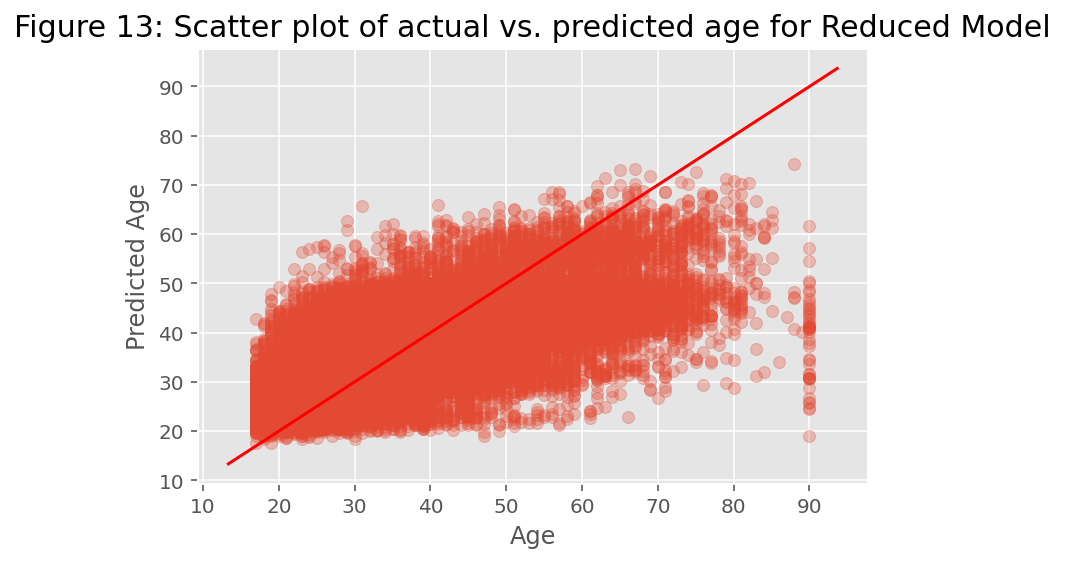

In [44]:
# get a scatter plot
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Age');
plt.ylabel('Predicted Age');
plt.title('Figure 13: Scatter plot of actual vs. predicted age for Reduced Model', fontsize=15);
plt.show(); 

This model returns an Adjusted R-squared of 0.404, meaning the reduced model still explains about 40% of the variance, but with 6 less variables. Looking at the p-values, they are all significant at the 5% level, as expected. From Figure 13, we still have the same issues with our model. That is, the model overestimates younger ages and underestimates older ages. We will now perform the diagnostic checks on this reduced model. 

### Reduced Model Diagnostic Checks

Let's first get a scatter plot of residuals (as a function of predicted age).

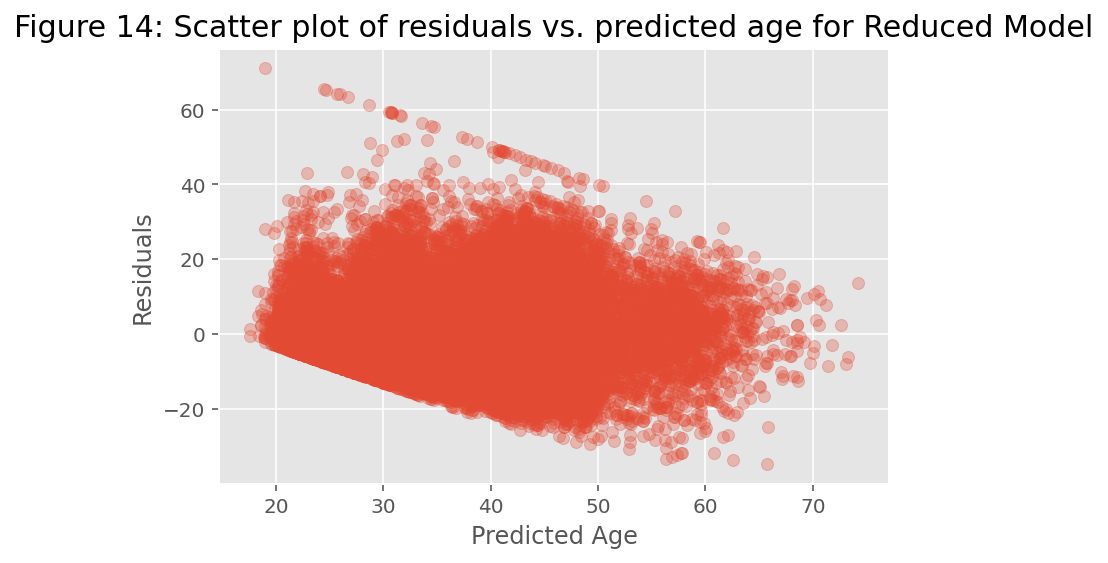

In [45]:
plt.scatter(residuals_reduced['predicted'], residuals_reduced['residual'], alpha=0.3);
plt.xlabel('Predicted Age');
plt.ylabel('Residuals')
plt.title('Figure 14: Scatter plot of residuals vs. predicted age for Reduced Model', fontsize=15)
plt.show();

Figure 14 looks very similar to Figure 10(a), suggesting that the residuals exhibit the same banding pattern.

Let's now have look at the histogram of the residuals for the reduced model.

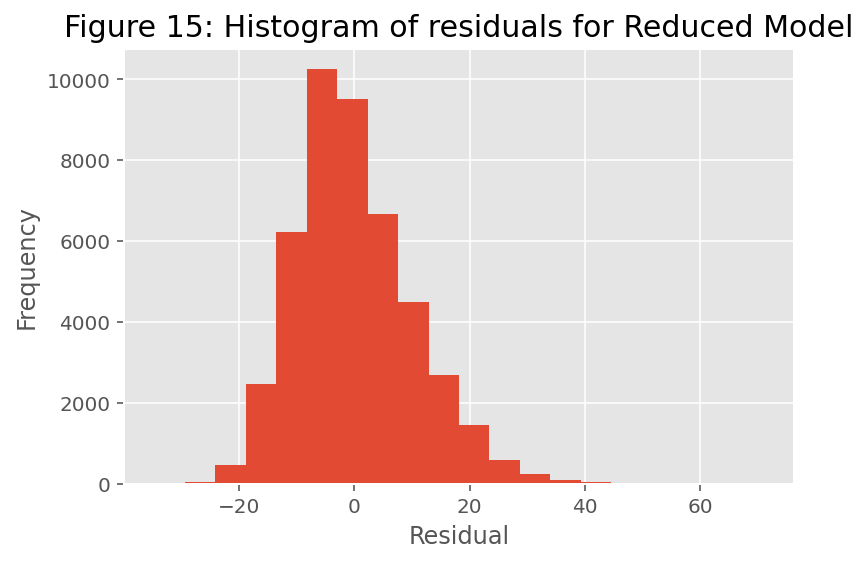

In [46]:
plt.hist(residuals_reduced['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 15: Histogram of residuals for Reduced Model', fontsize = 15)
plt.show();

From Figure 15, there is again a somewhat symmetric histogram around zero, which suggests that the residuals are somewhat normally distributed.

## Summary and Conclusions

Using our independent variables, we were able to get a full model with an Adjusted R-squared value of about 40%. After backwards variable selection with a p-value cutoff value of 0.05, we were able to maintain the same performance but with 6 less variables. Our final model has 49 variables all together with a model p-value of 0.

Diagnostic checks with residual scatter plots indicate that, rather than being random and centered around 0, the residuals exhibit a banding pattern, especially when predicted age is below 50. This pattern indicates that the constant variability assumption of linear regression is not quite satisfied in this case. On the other hand, residual histograms suggest that there are no significant violations of the normality assumption on the residuals. 

The final multiple linear regression model has an Adjusted R-squared value of about 40%, which is pretty low. So, it appears that the variables we used are not quite adequate for accurately predicting the age of an individual in the 1994 US Census dataset within a multiple linear regression framework. A good next step might involve adding some more interaction terms and maybe some other higher order terms to see if this would result in some improvement for the Adjusted R-squared value. Nonetheless, it might be the case that nonlinear models such as a neural network might be more appropriate for the task at hand rather than a linear regression model.

Our regression model appears to predict age correctly within $\pm40$ years in general, though this is clearly a huge margin of error for the model to be useful for any practical purposes. Furthermore, our model has some rather significant issues. Specifically, our model consistently overestimates younger ages and underestimates older ages. In particular, for those younger than the age of 30, the model predicts much older ages. Also, for those above the age of 80, the model predicts significantly younger ages.

## References

- Lichman, M. (2013).  UCI Machine Learning Repository [online]. Available at
https://archive.ics.uci.edu/ml/datasets/adult [Accessed 2019-08-20]